# XOR (TensorFlow)

[![Open in Colab](https://lab.aef.me/files/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/lab/blob/main/files/tf/xor.ipynb)
[![Open in Kaggle](https://lab.aef.me/files/assets/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/adamelliotfields/lab/blob/main/files/tf/xor.ipynb)
[![Render nbviewer](https://lab.aef.me/files/assets/nbviewer_badge.svg)](https://nbviewer.org/github/adamelliotfields/lab/blob/main/files/tf/xor.ipynb)

Given the following truth table:

| A | B | A ^ B |
|---|---|-------|
| 0 | 0 | 0     |
| 0 | 1 | 1     |
| 1 | 0 | 1     |
| 1 | 1 | 0     |

We can train a neural network to predict the XOR of two binary inputs.

In Python, XOR is represented by the caret `^`. In TensorFlow, XOR is implemented by the `tf.math.logical_xor` function.

The traditional `or` operator is the _inclusive or_. So, `True or True` is `True`. The XOR operation is _exclusive_, so `True ^ True` is `False` (but `True ^ False` is `True`).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from datetime import datetime
from tensorflow.keras import Input, Sequential, layers
from tensorflow.keras.callbacks import Callback, TensorBoard
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import AdamW

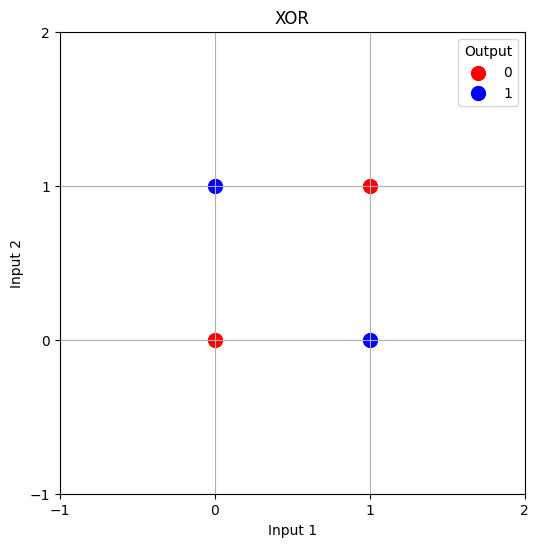

In [2]:
# plot xor
inputs = [(0, 0), (0, 1), (1, 0), (1, 1)]
outputs = [0, 1, 1, 0]

# separate into two lists for plotting
x_vals = [x[0] for x in inputs]
y_vals = [x[1] for x in inputs]

# scatter
plt.figure(figsize=(6, 6))
for i in range(len(inputs)):
    if outputs[i] == 0:
        plt.scatter(x_vals[i], y_vals[i], color="red", s=100, label="0" if i == 0 else "")
    else:
        plt.scatter(x_vals[i], y_vals[i], color="blue", s=100, label="1" if i == 1 else "")

# labels
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.title("XOR")
plt.xticks([-1, 0, 1, 2])
plt.yticks([-1, 0, 1, 2])
plt.legend(title="Output")
plt.grid(True)
plt.show()

In [3]:
# custom progress bar
class ProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params["epochs"]

    def on_epoch_end(self, epoch, logs=None):
        # every 100th
        if epoch == 0 or (epoch + 1) % 100 == 0:
            print(
                f"Epoch {epoch + 1}/{self.epochs}: loss={logs['loss']:.4f}, accuracy={logs['accuracy']:.4f}"
            )


progress_bar = ProgressBar()

# use He initialization
initializer = HeNormal(seed=42)

# Adam with weight decay
optimizer = AdamW(learning_rate=0.001, weight_decay=0.001)

# xor returns 1 if inputs are not equal and 0 otherwise
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
y = np.array([[0], [1], [1], [0]], dtype=np.float32)

# model
# gelu (Gaussian error) performs better than relu
model = Sequential(
    [
        Input(shape=(2,)),
        layers.Dense(16, activation="gelu", kernel_initializer=initializer),
        layers.Dense(16, activation="gelu", kernel_initializer=initializer),
        layers.Dense(1, activation="sigmoid"),
    ]
)

# TODO: tensorboard
# TODO: early stopping
# TODO: ipywidgets UI for inference
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X, y, epochs=500, batch_size=4, verbose=0, callbacks=[progress_bar])

Epoch 1/500: loss=0.7459, accuracy=0.7500
Epoch 100/500: loss=0.4549, accuracy=1.0000
Epoch 200/500: loss=0.1752, accuracy=1.0000
Epoch 300/500: loss=0.0497, accuracy=1.0000
Epoch 400/500: loss=0.0197, accuracy=1.0000
Epoch 500/500: loss=0.0103, accuracy=1.0000


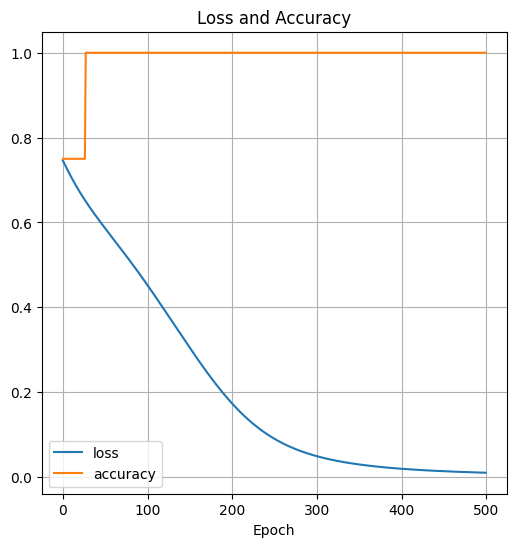

In [4]:
# plot loss and accuracy
plt.figure(figsize=(6, 6))
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["accuracy"], label="accuracy")
plt.xlabel("Epoch")
plt.title("Loss and Accuracy")
plt.grid(True)
plt.legend()
plt.show()